# Image Preprocessing
The data being used in this project comes from the [Kaggle Data Science Bowl 2018](https://www.kaggle.com/c/data-science-bowl-2018). The goal of this competition is to locate various nuclei within an image and detect each instance of it down to the exact pixel. The dataset consists of RGB images of microscope images. Each image comes with a prelabeled masks for each nuclei in an image. 

The purpose of this notebook is to preprocess the images in such a way that I can create a training and label dataset from this raw data. In order to do this, I resized each image to a uniform size of (256,256,3), while keeping track of it's original dimensions for later reference. For the labels, they are given as a binary mask, one for each instance of a nuclei. Therefore to make prediction simpler, I combined these images into a single mask. While this will fail to detect **instances**, we can use other traditional computer vision methods to split the predicted mask.

Once the images have been formatted, they will be pickled, or simply stored, for quick reading when user later on.

In [1]:
%load_ext memory_profiler

In [2]:
%memit

peak memory: 44.36 MiB, increment: 0.21 MiB


In [3]:
from os import listdir, walk
import os
import matplotlib.pyplot as plt
import numpy as np
from imageio import imread
import pickle

## Training Images and Labels

In [1]:
def read_images(path):
    """ Read Images and Masks from Path

        Arguments:
            path
        
        Return:
            dictionary of image, indexed by image name
    """
    
    images = {}
    
    count = 0

    for root,dirs,files in os.walk(path):
        
        if 'images' in dirs:
            for img_name in listdir(root + '/images'):
                
                if count % 50 == 0:
                    print("Read {} image/mask pairs".format(count))
                count += 1
                
                # Read Images
                img_path = root + '/images/%s' % img_name
                if img_path == '':
                    raise Exception("No Images found in directory")   
                img = imread(img_path)[:,:,:3]
                images[img_name] = img

    return images


In [5]:
images = read_images("./train_data")
pickle.dump(images, open('raw_images.p', 'wb'))

In [2]:
def read_masks(path):
    """ Read Images and Masks from Path

        Arguments:
            path
        
        Return:
            dictionary of masks, indexed by corresponding image name
    
    
    """

    masks = {}
    
    count = 0

    for root,dirs,files in os.walk(path):
        
        if 'images' in dirs:
            for img_name in listdir(root + '/images'):
                
                if count % 50 == 0:
                    print("Read {} image/mask pairs".format(count))
                count += 1

                # Read Masks
                submasks = []
                for mask_name in listdir(root + '/masks'):
                    mask_path = root + '/masks/{}'.format(mask_name)
                    if mask_path == '':
                        raise Exception("No Masks found in directory")  
                    submasks.append(imread(mask_path))
                masks[img_name] = submasks
    return masks

masks = read_masks("./train_data")
pickle.dump(masks, open('raw_masks.p', 'wb'))

Read 0 image/mask pairs
Read 50 image/mask pairs
Read 100 image/mask pairs
Read 150 image/mask pairs
Read 200 image/mask pairs
Read 250 image/mask pairs
Read 300 image/mask pairs
Read 350 image/mask pairs
Read 400 image/mask pairs
Read 450 image/mask pairs
Read 500 image/mask pairs
Read 550 image/mask pairs
Read 600 image/mask pairs
Read 650 image/mask pairs


## Test Images
These images are separate from training dataset, which have labeled masks associated with them. This dataset is purely for submission purposes.

In [9]:
def read_test_images(path):
    """ Read Images and Masks from Path

        Arguments:
            path
        
        Return:
            dictionary of image names, each containing dictionary of {image,masks}.
    
    
    """
    
    images = {}
    sizes = []
    img_names = []
    
    count = 0

    for root,dirs,files in os.walk(path):
        
        if 'images' in dirs:
            for img_name in listdir(root + '/images'):
                
                if count % 50 == 0:
                    print("Read {} image/mask pairs".format(count))
                count += 1
                
                # Read Images
                img_path = root + '/images/%s' % img_name
                if img_path == '':
                    raise Exception("No Images found in directory")   
                img = imread(img_path)
                if img.shape[-1] != 3:
                    try:
                        img = img[:,:,:3]
                    except IndexError:
                        img = np.expand_dims(img,axis=-1)
                        img = np.repeat(img,3, axis=-1)
                images[img_name] = img
                sizes.append(img.shape)
                img_names.append(img_name)

    return images, sizes, img_names


In [13]:
test_images, test_sizes, img_names = read_test_images("../stage_2")
pickle.dump(test_images, open('raw_test_images.p', 'wb'))
pickle.dump(test_sizes, open('test_sizes.p', 'wb'))
pickle.dump(img_names, open('test_img_names.p', 'wb'))

Read 0 image/mask pairs
Read 50 image/mask pairs
Read 100 image/mask pairs
Read 150 image/mask pairs
Read 200 image/mask pairs
Read 250 image/mask pairs
Read 300 image/mask pairs
Read 350 image/mask pairs
Read 400 image/mask pairs
Read 450 image/mask pairs
Read 500 image/mask pairs
Read 550 image/mask pairs
Read 600 image/mask pairs
Read 650 image/mask pairs
Read 700 image/mask pairs
Read 750 image/mask pairs
Read 800 image/mask pairs
Read 850 image/mask pairs
Read 900 image/mask pairs
Read 950 image/mask pairs
Read 1000 image/mask pairs
Read 1050 image/mask pairs
Read 1100 image/mask pairs
Read 1150 image/mask pairs
Read 1200 image/mask pairs
Read 1250 image/mask pairs
Read 1300 image/mask pairs
Read 1350 image/mask pairs
Read 1400 image/mask pairs
Read 1450 image/mask pairs
Read 1500 image/mask pairs
Read 1550 image/mask pairs
Read 1600 image/mask pairs
Read 1650 image/mask pairs
Read 1700 image/mask pairs
Read 1750 image/mask pairs
Read 1800 image/mask pairs
Read 1850 image/mask pai

In [8]:
test_images, test_sizes, img_names = read_test_images("./test_data_2")

In [16]:
pickle.dump(test_images, open('../raw_test_images.p', 'wb'))
pickle.dump(test_sizes, open('../test_sizes.p', 'wb'))
pickle.dump(img_names, open('../test_img_names.p', 'wb'))

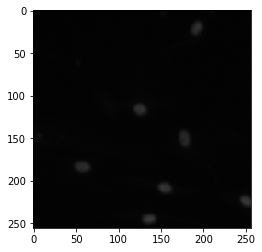

In [15]:
plt.imshow(test_images[list(test_images.keys())[0]])

In [12]:
print(test_images)

{}
